# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
real_estate_data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
#real_estate_data.head(20)
#real_estate_data
real_estate_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

**Пропущенные значения есть, некоторые даже важные.**
1. Далеко не везде указана *высота потолков*. Т.к. это СПб, она может быть разная даже в рамках одной квартиры, особенно это касается центра.
2. Есть небольшое количество, где не указана *этажность*, попробуем определить по косвенным параметрам.
3. *Жилая площадь* - тоже не везде. Надо смотреть, какие данные еще есть, чтобы ее определить.
4. Колонка *"Апартаменты"* - практически не заполнена, да это и не важно, для текущего анализа она не нужна.
5. *Балкона* действительно может не быть, но посмотрим.
6. *Расстояние до аэропорта и центра* - постараемся вычислить по населенному пункту (если это не СПБ).
7. А вот отсутствие *населенного пункта* - это плохо. Не будут участвовать в статистике по населенным пунктам.
8. Зоны отдыха - *парки* и *пруды* попробуем заполнить по косвенным признакам.
9. *Количество дней публикации*, конечно важный показатель, но не для текущего исследования.

### Шаг 2. Предобработка данных

In [2]:
# Заменим пустые значения высоты потолков на 0, удалять пока не будем
# т.к. квартир без потолков быть не может, лучше потом исключим из соответствующей выборки
real_estate_data['ceiling_height'] = real_estate_data['ceiling_height'].fillna(0)

# Заменим пустые значения этажности на 0, удалять пока не будем,
# т.к. зданий без этажей быть не может, лучше потом исключим из соответствующей выборки
real_estate_data['floors_total'] = real_estate_data['floors_total'].fillna(0)

"""
!! Комментарий ревьюера:
    хорошее решение, единственное, я бы посоветовала явно проверить данные:
    нет ли у нас объектов, в которых высота потолков/этажность уже == 0? 
    Если у тебя была проверка, стоило оставить код :) А если не было - не
    нужно рассчитывать на адекватность данных, помимо пропусков у нас вполне
    могут быть и аномалии, такие, как нулевая высота потолков. Пропущенные
    и аномальные значения значения важно различать, так как у них может быть
    разная причина возникновения.
"""

# Заменим пустые значения аппартаментов на False 
# (предположим, что в нашей стране пока не распространено понятие "аппартаменты")
real_estate_data['is_apartment'] = real_estate_data['is_apartment'].fillna(False)

# Заменим пустые значения балконов на 0, будем считать их не указали
real_estate_data['balcony'] = real_estate_data['balcony'].fillna(0)

# заменим пустые значения в столбце со значением населенного пункта на значение 'Не указан',
# удалять пока не будем, лучше потом исключим из соответствующей выборки
real_estate_data['locality_name'] = real_estate_data['locality_name'].fillna('Не указан')

# Заменим пустые значения близости до аэропорта на 0, удалять пока не будем
# т.к. дом не может стоять на территории аэропорта, лучше потом исключим из соответствующей выборки
real_estate_data['airports_nearest'] = real_estate_data['airports_nearest'].fillna(0)

#real_estate_data.query('(open_plan == True)|(open_plan == True)').info()
#real_estate_data.query('(open_plan == True)|(open_plan == True)|(is_apartment == True)').info()

# Заменим пустые значения площади кухни на 0, удалять пока не будем
# т.к. вряд-ли есть квартиры без кухни, лучше потом исключим из соответствующей выборки
real_estate_data['kitchen_area'] = real_estate_data['kitchen_area'].fillna(0)

# Заменим пустые значения жилой площади на 0, удалять пока не будем
# т.к. вряд-ли есть квартиры без жилой площади, лучше потом исключим из соответствующей выборки
real_estate_data['living_area'] = real_estate_data['living_area'].fillna(0)

#real_estate_data.query('(cityCenters_nearest == 0)').info()
# Заменим пустые значения расстояния от центра на 0, удалять пока не будем
# т.к. в выборке нет квартир, находящихся на дворцовой площади, 
# лучше потом исключим из соответствующей выборки
real_estate_data['cityCenters_nearest'] = real_estate_data['cityCenters_nearest'].fillna(0)

#real_estate_data.query('(days_exposition == 0)').info()
# Заменим пустые значения количества дней объявления на 0, удалять пока не будем
# т.к. будем считать, что это квартиры, проданные в тот же день, лучше потом исключим из соответствующей выборки
real_estate_data['days_exposition'] = real_estate_data['days_exposition'].fillna(0)

# Заменим пустые значения расстояния до ближайшего парка или пруда на 0, удалять пока не будем
# т.к. дом не может находиться в парке или в пруду, лучше потом исключим из соответствующей выборки
real_estate_data['parks_nearest'] = real_estate_data['parks_nearest'].fillna(0)
real_estate_data['ponds_nearest'] = real_estate_data['ponds_nearest'].fillna(0)

#real_estate_data.query('(parks_nearest != 0)&(parks_around3000 == 0)').info()
#real_estate_data.query('(ponds_around3000 == 0)').info()
# Заменим пустые значения количества парков или прудов на 0, удалять пока не будем
# т.к. это автоматически заполненные данные, скорее всего действительно нет рядом их,
# лучше потом исключим из соответствующей выборки
real_estate_data['parks_around3000'] = real_estate_data['parks_around3000'].fillna(0)
real_estate_data['ponds_around3000'] = real_estate_data['ponds_around3000'].fillna(0)

# преобразуем значения цены, этажности, наличия балконов, расстояния до аэропорта или центра
# количества парков, прудов и расстояния до них, количества дней в целочисленные,
# нет смысла их держать плавающими
real_estate_data['last_price'] = real_estate_data['last_price'].astype('int')
real_estate_data['floors_total'] = real_estate_data['floors_total'].astype('int')
real_estate_data['balcony'] = real_estate_data['balcony'].astype('int')
real_estate_data['airports_nearest'] = real_estate_data['airports_nearest'].astype('int')
real_estate_data['cityCenters_nearest'] = real_estate_data['cityCenters_nearest'].astype('int')
real_estate_data['parks_around3000'] = real_estate_data['parks_around3000'].astype('int')
real_estate_data['parks_nearest'] = real_estate_data['parks_nearest'].astype('int')
real_estate_data['ponds_around3000'] = real_estate_data['ponds_around3000'].astype('int')
real_estate_data['ponds_nearest'] = real_estate_data['ponds_nearest'].astype('int')
real_estate_data['days_exposition'] = real_estate_data['days_exposition'].astype('int')


#real_estate_data.info()
real_estate_data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,False,...,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,0
1,7,3350000,40.4,2018-12-04T00:00:00,1,0.00,11,18.6,1,False,...,11.0,2,посёлок Шушары,12817,18603,0,0,0,0,81
2,10,5196000,56.0,2015-08-20T00:00:00,2,0.00,5,34.3,4,False,...,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558
3,0,64900000,159.0,2015-07-24T00:00:00,3,0.00,14,0.0,9,False,...,0.0,0,Санкт-Петербург,28098,6800,2,84,3,234,424
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,False,...,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121


Заменим пустые значения высоты потолков на 0, удалять пока не будем
т.к. квартир без потолков быть не может, лучше потом исключим из соответствующей выборки

Заменим пустые значения этажности на 0, удалять пока не будем,
т.к. зданий без этажей быть не может, лучше потом исключим из соответствующей выборки

Заменим пустые значения аппартаментов на False 
(предположим, что в нашей стране пока не распространено понятие "аппартаменты")

Заменим пустые значения балконов на 0, будем считать их не указали

Заменим пустые значения в столбце со значением населенного пункта на значение 'Не указан',
удалять пока не будем, лучше потом исключим из соответствующей выборки

Заменим пустые значения близости до аэропорта на 0, удалять пока не будем
т.к. дом не может стоять на территории аэропорта, лучше потом исключим из соответствующей выборки

Заменим пустые значения площади кухни на 0, удалять пока не будем
т.к. вряд-ли есть квартиры без кухни, лучше потом исключим из соответствующей выборки

Заменим пустые значения жилой площади на 0, удалять пока не будем
т.к. вряд-ли есть квартиры без жилой площади, лучше потом исключим из соответствующей выборки

Заменим пустые значения расстояния от центра на 0, удалять пока не будем
т.к. в выборке нет квартир, находящихся на дворцовой площади, 
лучше потом исключим из соответствующей выборки

Заменим пустые значения количества дней объявления на 0, удалять пока не будем
т.к. будем считать, что это квартиры, проданные в тот же день, лучше потом исключим из соответствующей выборки

Заменим пустые значения расстояния до ближайшего парка или пруда на 0, удалять пока не будем
т.к. дом не может находиться в парке или в пруду, лучше потом исключим из соответствующей выборки

Заменим пустые значения количества парков или прудов на 0, удалять пока не будем
т.к. это автоматически заполненные данные, скорее всего действительно нет рядом их,
лучше потом исключим из соответствующей выборки

преобразуем значения цены, этажности, наличия балконов, расстояния до аэропорта или центра
количества парков, прудов и расстояния до них, количества дней в целочисленные,
нет смысла их держать плавающими


### Шаг 3. Посчитайте и добавьте в таблицу

In [3]:
# посчитаем цену за квадратный метр и приведем ее к целому 
real_estate_data['price_for_square_meter'] = real_estate_data['last_price'] / real_estate_data['total_area']
real_estate_data['price_for_square_meter'] = real_estate_data['price_for_square_meter'].astype('int')

def day_of_publication(row):
    number_of_weekday = row['number_of_weekday_publication']
    if number_of_weekday == 0:
        return '1 понедельник'
    elif number_of_weekday == 1:
        return '2 вторник'
    elif number_of_weekday == 2:
        return '3 среда'
    elif number_of_weekday == 3:
        return '4 четверг'
    elif number_of_weekday == 4:
        return '5 пятница'
    elif number_of_weekday == 5:
        return '6 суббота'
    elif number_of_weekday == 6:
        return '7 воскресенье'
    else:
        return 'не определен'
    

# приведем строковый параметр к времени и вычислим день недели, месяц и год объявления
real_estate_data['first_day_exposition'] = pd.to_datetime(real_estate_data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
real_estate_data['number_of_weekday_publication'] = real_estate_data['first_day_exposition'].dt.weekday
real_estate_data['day_of_week_publication'] = real_estate_data.apply(day_of_publication, axis=1)
real_estate_data['month_publication'] = real_estate_data['first_day_exposition'].dt.month
real_estate_data['year_publication'] = real_estate_data['first_day_exposition'].dt.year

# Вычислим отношение площади кухни и жилой площади к общей 
real_estate_data['kitchen_attitude'] = real_estate_data['kitchen_area'] / real_estate_data['total_area']
real_estate_data['live_attitude'] = real_estate_data['living_area'] / real_estate_data['total_area']

# функция, которая по данным строки классифицирует этаж.
# т.к. ранее мы оставили строки в которых этажность не заполнена,
# необходимо ввести еще одну категорию - 'Не определен'
def set_floor_definition(row):
    if row['floor'] == 1:
        return '1. Первый'
    elif row['floors_total'] != 0:
        if row['floors_total'] == row['floor']:
            return '2. Последний'
        else:
            return '3. Другой'
    else:
        return '4. Не определен'
    
# применим функцию к таблице
real_estate_data['flor_classified'] = real_estate_data.apply(set_floor_definition, axis=1)

real_estate_data['flor_classified'].value_counts()


3. Другой          17363
2. Последний        3336
1. Первый           2917
4. Не определен       83
Name: flor_classified, dtype: int64

Значения добавил, таблицу пока никак не "резал" и не "фильтровал". Все будем делать при анализе.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

In [4]:
# Импортируем графическую библиотеку
import matplotlib.pyplot as plt

Сформировал набор функций для того, чтобы упорядчить вывод и сократить количество повторяющегося кода

In [5]:
# Выберем 10 населенных пунктов с наибольшим количеством объявлений
real_estate_locality_name_count = (real_estate_data
                                      .pivot_table(index='locality_name', 
                                                   values=['price_for_square_meter'], 
                                                   aggfunc=['count'])
                                     )

real_estate_locality_name_count.columns = ['publications_count']

# Сохраним этот список в переменную индексов
real_estate_price_count_top_10 = (real_estate_locality_name_count.sort_values(by='publications_count', ascending = False)
                                  .head(10).index
                                 )

# Выберем сводную таблицу со средней ценой за квадратный метр
real_estate_price_median_top_10_counts = (real_estate_data.query('locality_name in @real_estate_price_count_top_10')
                                          .pivot_table(index='locality_name', 
                                          values=['price_for_square_meter'], 
                                          aggfunc=['median'])
                                         )
                                          
real_estate_price_median_top_10_counts.columns = ['price_mean']

print(real_estate_price_median_top_10_counts.sort_values(by='price_mean', ascending = False))

                   price_mean
locality_name                
Санкт-Петербург      104761.0
Пушкин               100000.0
деревня Кудрово       91860.0
посёлок Парголово     91642.0
посёлок Мурино        85878.0
посёлок Шушары        76876.0
Колпино               74723.5
Гатчина               67796.0
Всеволожск            65789.0
Выборг                58158.0


Наибольшую и наименьшую цену не выводил, из таблицы это и так видно

AxesSubplot(0.125,0.125;0.775x0.755)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

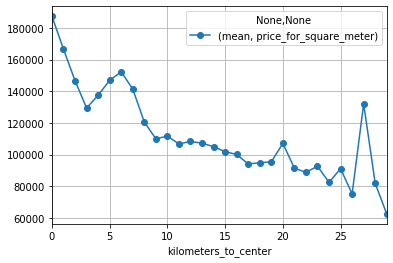

In [6]:
# Построим график зависимости цены от расстояния до центра

# Выберем все объявления по СПб
real_estate_data_spb = real_estate_data.loc[(real_estate_data['locality_name'] == 'Санкт-Петербург')
                                            &(real_estate_data['cityCenters_nearest'] != 0)]

# Добавим колонку расстояния в километрах (целочисленную)
def meters_to_kilometers(row):
    return int(row['cityCenters_nearest'] / 1000)

real_estate_data_spb['kilometers_to_center'] = real_estate_data_spb.apply(meters_to_kilometers, axis = 1)

# Сформируем сводную таблицу средней цены для каждого километра удаленности от центра 
real_estate_data_spb_to_center = (real_estate_data_spb
                                  .pivot_table(index='kilometers_to_center', 
                                               values=['price_for_square_meter'], 
                                               aggfunc=['mean'])
                                 )

# Выведем график средней цены от расстояния до центра
plt.figure(1)
print(real_estate_data_spb_to_center.plot(style='o-', grid=True))

# График сильно меняется на 9 км. Становится пологим. 
# Соответственно, более ровная застройка, не исторический центр
real_estate_data_spb_center = real_estate_data_spb.query('(kilometers_to_center <= 9)')



График сильно меняется на 9 км. Становится пологим.
Соответственно, это более ровная застройка, не исторический центр.

In [7]:
# Напишем функции, чтобы легче было структурировать

# Функция возвращает массив выборок из общей таблицы
def dataframes_list(df_in):
    list_of_dataframes = []

    # Полная таблица [0]
    list_of_dataframes.append(df_in)

    # Выборка для площади [1]
    real_estate_data_area = df_in.loc[:,('total_area')]
    list_of_dataframes.append(real_estate_data_area)

    # Выборка для цены за квадратный метр [2]
    real_estate_data_price = df_in.loc[:,('price_for_square_meter')]
    list_of_dataframes.append(real_estate_data_price)
 
    # Выборка для количества комнат [3]
    real_estate_data_rooms = df_in.loc[:,('rooms')]
    list_of_dataframes.append(real_estate_data_rooms)

    # Выборка для высоты потолков [4]
    # Мы заменяли пропуски на нулевые значения, поэтому их исключим
    real_estate_data_ceiling = df_in[df_in['ceiling_height'] != 0]['ceiling_height']
    list_of_dataframes.append(real_estate_data_ceiling)

    # Выборка для количества дней продажи [5]
    # Мы заменяли пропуски на нулевые значения, поэтому их исключим
    real_estate_data_time_sale = (
                    df_in[df_in['days_exposition']!=0]['days_exposition'])
    list_of_dataframes.append(real_estate_data_time_sale)

    # Выборка для зависимости от расстояния до центра [6]
    # Мы заменяли пропуски на нулевые значения, поэтому их исключим
    real_estate_data_center_from = df_in[df_in['cityCenters_nearest'] != 0]
    list_of_dataframes.append(real_estate_data_center_from)
   
    # Выборка для зависимости от дня недели публикации [7]
    real_estate_price_from_weekday = (df_in
                                      .pivot_table(index='day_of_week_publication', 
                                                   values=['price_for_square_meter'], 
                                                   aggfunc=['median'])
                                     )
    real_estate_price_from_weekday.columns = ['price_for_square_meter']

    list_of_dataframes.append(real_estate_price_from_weekday)

    # Выборка для зависимости от месяца публикации [8]
    real_estate_price_from_month = (df_in
                                  .pivot_table(index='month_publication', 
                                               values=['price_for_square_meter'], 
                                               aggfunc=['median'])
                                 )
    real_estate_price_from_month.columns = ['price_for_square_meter']

    list_of_dataframes.append(real_estate_price_from_month)

    # Выборка для зависимости от года публикации [9]
    real_estate_price_from_year = (df_in
                                      .pivot_table(index='year_publication', 
                                                   values=['price_for_square_meter'], 
                                                   aggfunc=['median'])
                                   )

    real_estate_price_from_year.columns = ['price_for_square_meter']
    
    list_of_dataframes.append(real_estate_price_from_year)

    return list_of_dataframes


# Функция, выводящая аналитику по выборке 
def df_description(df_in, frame_name, description_name):
    print(frame_name, description_name)
    print('')
    print(df_in.describe())
    print('')
    print('')


# функция для вывода корреляции колонок
def df_corellation(df_in, frame_name, column_name, second_parametr_name):

    # Вычислим коэффициент корреляции
    coef_correlation = df_in['price_for_square_meter'].corr(df_in[column_name])
    
    # Выведем шапку
    print(frame_name, 'Вычислим зависимость цены квадратного метра от параметра ', second_parametr_name)
    print('')
    print('Коэф. корреляции:', coef_correlation)
    print('')

    # Выведем вывод
    if coef_correlation == 0:
        print('Зависимости между параметрами нет')
    elif coef_correlation > 0:
        if coef_correlation > 0.7:
            print('Зависимость сильная, чем выше', second_parametr_name, 'тем выше цена')
        elif coef_correlation > 0.3:
            print('Зависимость средняя, чем выше', second_parametr_name, 'тем выше цена')
        else:
            print('Зависимость слабая, чем выше', second_parametr_name, 'тем выше цена')
    else:        
        if coef_correlation < -0.7:
            print('Зависимость сильная, чем выше', second_parametr_name, 'тем ниже цена')
        elif coef_correlation < -0.3:
            print('Зависимость средняя, чем выше', second_parametr_name, 'тем ниже цена')
        else:
            print('Зависимость слабая, чем выше', second_parametr_name, 'тем ниже цена')
    print('')
    print('')
    

# Зависимость цены квадратного метра от этажа (певый, последний и другой)
def df_floor_dependence(df_in, frame_name):

    print(frame_name, 'Зависимость цены квадратного метра от этажа (певый, последний и другой)')
    print('')

    # Сделаем выборку 
    real_estate_price_from_floor = df_in.loc[(df_in['flor_classified'] != '4. Не определен')]

    real_estate_price_from_floor_pivot = real_estate_price_from_floor.pivot_table(index='flor_classified', 
                                                                                  values='price_for_square_meter',
                                                                                  #aggfunc=['median', 'count'])
                                                                                  aggfunc=['median'])

    # Переименуем колонки
    real_estate_price_from_floor_pivot.columns = ['publications_count']

    print(real_estate_price_from_floor_pivot)
    
    print('')
    print('')
    

# Функция, выводящая гистограмму по выборке 
def df_histogram(df_in, frame_name, description_name, figure_number, bins_all, bins_filtered, range_start, range_finish):
    #plt.ylim(range_start, range_finish)
    #real_estate_data_area.boxplot()
    plt.figure(figure_number)
    df_in.hist(bins = bins_all)
    plt.figure(figure_number+1)
    df_in.hist(bins = bins_filtered, range = (range_start,range_finish))


# Функция вывода диаграммы зависимости от размещения объявления
def df_publication_dependence_diagram(df_in, frame_name, diagram_name, figure_number):
    plt.figure(figure_number)
    full_diagram_name = frame_name + diagram_name
    df_in.plot(grid=True, title = full_diagram_name);

# Определим функции, которые будем вызывать как для общей таблицы, так и для выборки по СПб

# Функция формирования описаний
def df_descriptions(list_of_dataframes, frame_name):
    
    # Исследуем площадь
    df_description(list_of_dataframes[1], frame_name, 'Общая площадь. Параметры распределения.')

    # Исследуем цену квадратного метра
    df_description(list_of_dataframes[2], frame_name, 'Цена квадратного метра. Параметры распределения.')

    # Исследуем число комнат
    df_description(list_of_dataframes[3], frame_name, 'Число комнат. Параметры распределения.')

    # Исследуем высоту потолков. там были нулевые значения, поэтому их исключим
    df_description(list_of_dataframes[4], frame_name, 'Высота потолков. Параметры распределения.')

    # Исследуем время продажи в днях. там были нулевые значения, поэтому их исключим
    #plt.ylim(1, 600)
    df_description(list_of_dataframes[5], frame_name, 'Время продажи в днях. Параметры распределения.')

    # Корреляция цены квадратного метра и площади
    df_corellation(list_of_dataframes[0], frame_name, 'total_area', 'общая площадь')
    
    # Корреляция цены квадратного метра и количества комнат
    df_corellation(list_of_dataframes[0], frame_name, 'rooms', 'количество комнат')

    # Корреляция цены квадратного метра и удаленности от центра 
    df_corellation(list_of_dataframes[6], frame_name, 'cityCenters_nearest', 'расстояние до центра')

    # Зависимость цены квадратного метра от этажа (певый, последний и другой)
    df_floor_dependence(list_of_dataframes[0], frame_name)


# функция для формирования диаграмм
def df_histograms(list_of_dataframes, frame_name):
    
    # Зависимость от дня недели, когда было размещено объявление
    df_publication_dependence_diagram(list_of_dataframes[7], frame_name, 'Зависимость от дня недели, когда было размещено объявление', 10)

    # Зависимость от месяца, когда было размещено объявление
    #df_publication_dependence_diagram(list_of_dataframes[8], frame_name, 'Зависимость от месяца, когда было размещено объявление', 11)

    # Зависимость от года, когда было размещено объявление
    #df_publication_dependence_diagram(list_of_dataframes[9], frame_name, 'Зависимость от года, когда было размещено объявление', 12)

# Функция вывода текста на графике
def add_titlebox(ax, text, x_point, y_point):
    ax.text(x_point, y_point, text,
        horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.6),
        fontsize=12.5)
    return ax

# Функция для формирования двух диаграм рядом
def df_two_histograms(dataframe1, 
                      dataframe2, 
                      frame_name1, 
                      frame_name2, 
                      description_name, 
                      figure_number,
                      bins_number,
                      xlim_min,
                      xlim_max):

    # Определим параметры графиков
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2,
        figsize=(16, 6)
    )

    plt.figure(figure_number)

    #plt.title(description_name)
    
    plt.gca().set(title=description_name) #, ylabel='Frequency')

    ax1.hist(dataframe1, bins='auto', color = 'g', label = frame_name1)
    ax1.hist(dataframe2, bins='auto', color = 'b', label = frame_name2)

    ax2.hist(dataframe1, bins='auto', color = 'g', label = frame_name1)
    ax2.hist(dataframe2, bins='auto', color = 'b', label = frame_name2)

    plt.xlim(xlim_min,xlim_max)
    
    add_titlebox(ax1, 'Все значения',.55,.8)
    add_titlebox(ax2, 'Без выбросов',.55,.8)

    plt.legend()
    plt.plot()
    
# Функция вывода двух диаграмм по двум выборкам зависимости от размещения объявления
def df_publication_dependence_diagrams(dataframe1, 
                                       dataframe2,
                                       frame_name1, 
                                       frame_name2, 
                                       diagram_name, 
                                       column_name, 
                                       figure_number):
    
    max_y = max([max(dataframe1[column_name]),max(dataframe2[column_name])])*1.1
    min_y = min([min(dataframe1[column_name]),min(dataframe2[column_name])])*0.9
    
    
    # Plot
    plt.figure(figure_number, figsize=(8,5), dpi= 80)
    plt.ylabel('Стоимость квадратного метра', fontsize=10)  
    x = dataframe1.index
    plt.plot(x, dataframe1, color='r', lw=2, label = frame_name1) 
    plt.plot(x, dataframe2, color='g', lw=2, label = frame_name2) 
 
    # Decorations
    # Lighten borders
    plt.gca().spines["top"].set_alpha(0)
    plt.gca().spines["bottom"].set_alpha(1)
    plt.gca().spines["right"].set_alpha(0)
    plt.gca().spines["left"].set_alpha(1)
    plt.xticks(x, [str(d) for d in x] , fontsize=10)
    plt.title(diagram_name, fontsize=16)
    #plt.xlabel("Hour of Day")

    s, e = plt.gca().get_xlim()
    plt.xlim(s, e)
    plt.ylim(min_y, max_y)

    # Draw Horizontal Tick lines  
    for y in range(8, 20, 2):    
        plt.hlines(y, xmin=s, xmax=e, colors='black', alpha=0.5, linestyles="--", lw=0.5)

    plt.legend()
    plt.plot()
    

In [8]:

# Сформируем список выборок для общей таблицы
list_of_dataframes_all = dataframes_list(real_estate_data)

# Сформируем список выборок для таблицы центра СПб
list_of_dataframes_spb = dataframes_list(real_estate_data_spb_center)

# Вызовем функцию формирования описаний для общей таблицы    
df_descriptions(list_of_dataframes_all, 'Общая выборка.')

# Вызовем функцию формирования описаний для таблицы центра СПб  
df_descriptions(list_of_dataframes_spb, 'Санкт-Петербург.')



Общая выборка. Общая площадь. Параметры распределения.

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


Общая выборка. Цена квадратного метра. Параметры распределения.

count    2.369900e+04
mean     9.942121e+04
std      5.030681e+04
min      1.110000e+02
25%      7.658500e+04
50%      9.500000e+04
75%      1.142560e+05
max      1.907500e+06
Name: price_for_square_meter, dtype: float64


Общая выборка. Число комнат. Параметры распределения.

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


Общая выборка. Высота потолков. Параметры распределения.

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.6

Общая выборка
Зависимость есть, самые дешевые квартиры на первом этаже, 
на последнем в среднем дороже на 6,5 тыс. руб. за кв.м., 
а на других этажах еще дороже, на 10 тыс. рублей.

СПб
Зависимость есть, самые дешевые квартиры на первом этаже, 
на последнем в среднем дороже на 9 тыс. руб. за кв.м., 
а на других этажах также дороже на 9 тыс. рублей.

## ``median`` вместо ``mean``

В выборке для центра СПб отличие между ними на целых 15%. При распределении Пуассона на среднее обычно влияют аномально большие значения, поэтому медиана будет более наглядной.

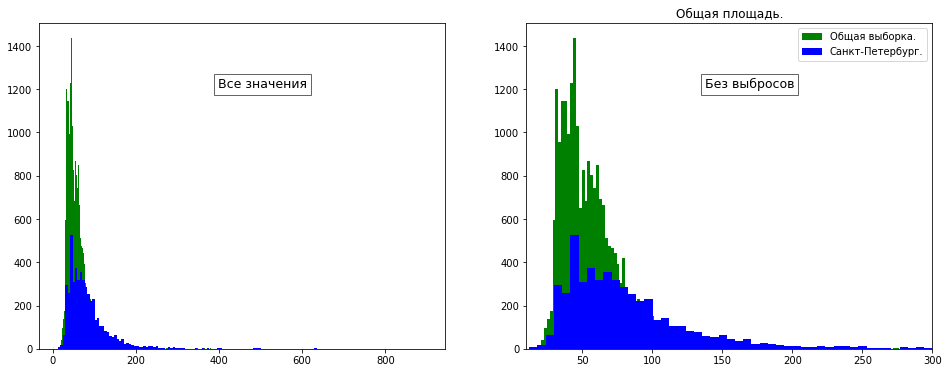

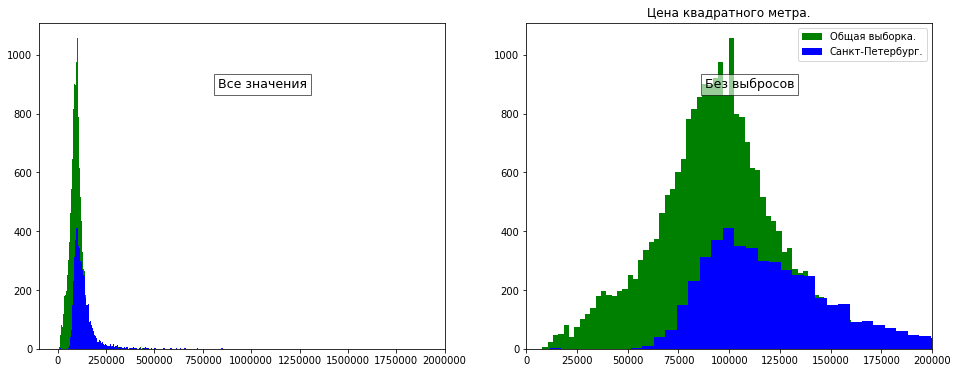

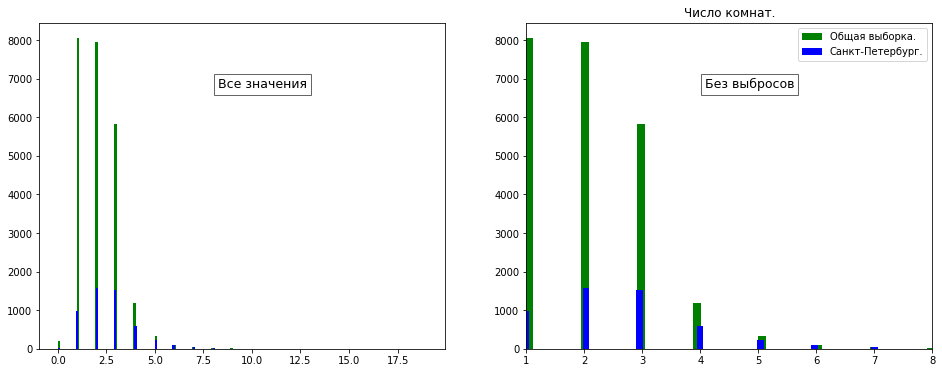

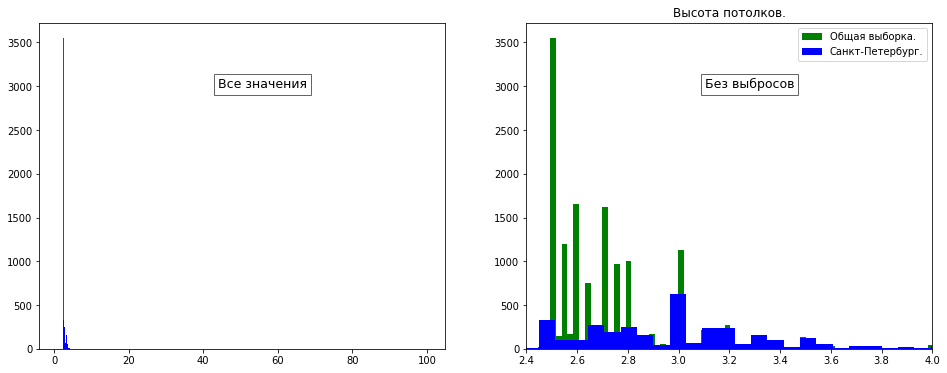

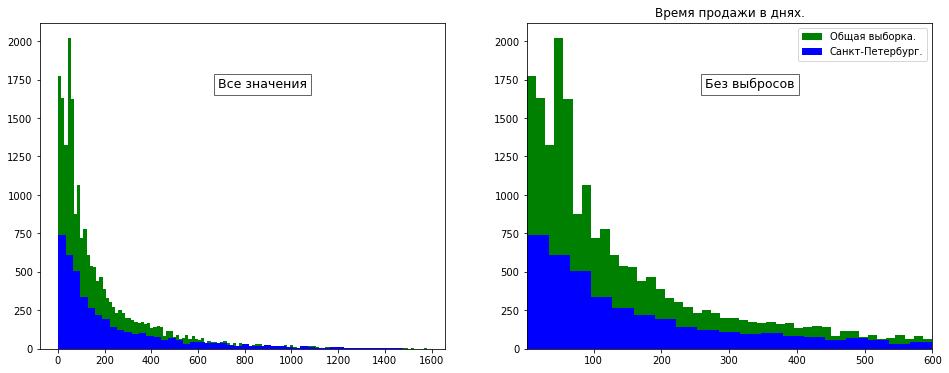

In [9]:
# Распределение площади
df_two_histograms(list_of_dataframes_all[1], 
                  list_of_dataframes_spb[1], 
                  'Общая выборка.', 
                  'Санкт-Петербург.', 
                  'Общая площадь.',
                  1,28,10,300)

# Распределение цены квадратного метра
df_two_histograms(list_of_dataframes_all[2], 
                  list_of_dataframes_spb[2], 
                  'Общая выборка.', 
                  'Санкт-Петербург.', 
                  'Цена квадратного метра.',
                  2,44,0,200000)

# Распределение числа комнат
df_two_histograms(list_of_dataframes_all[3], 
                  list_of_dataframes_spb[3], 
                  'Общая выборка.', 
                  'Санкт-Петербург.', 
                  'Число комнат.',
                  3,8,1,8)

# Распределение высоты потолков
df_two_histograms(list_of_dataframes_all[4], 
                  list_of_dataframes_spb[4], 
                  'Общая выборка.', 
                  'Санкт-Петербург.', 
                  'Высота потолков.',
                  4,20,2.4,4)

# Распределение времени продажи в днях
df_two_histograms(list_of_dataframes_all[5], 
                  list_of_dataframes_spb[5], 
                  'Общая выборка.', 
                  'Санкт-Петербург.', 
                  'Время продажи в днях.',
                  5,25,1,600)



Время продажи в днях.
Вполне обычное распределение Пуассона, не знаю что и откинуть...
Пока отброшу объявления с сроком продажи более 600 дней...



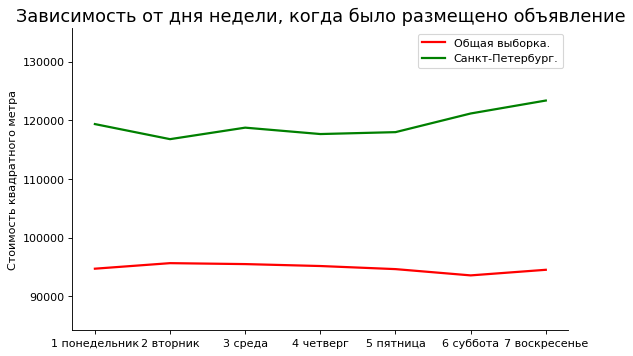

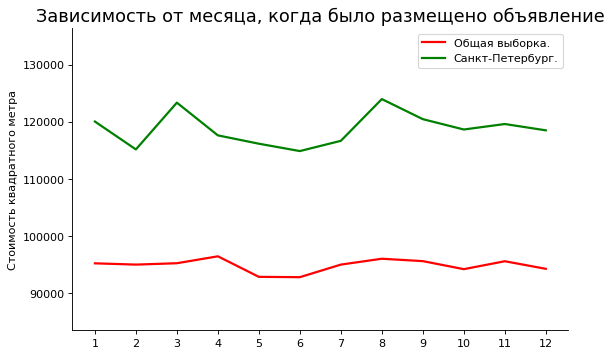

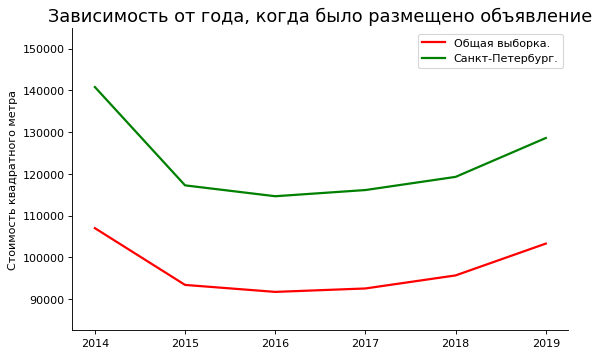

In [10]:
# Зависимость от дня недели, когда было размещено объявление
df_publication_dependence_diagrams(list_of_dataframes_all[7], 
                                   list_of_dataframes_spb[7],
                                   'Общая выборка.', 
                                   'Санкт-Петербург.', 
                                   'Зависимость от дня недели, когда было размещено объявление', 
                                   'price_for_square_meter',
                                   10)

# Зависимость от месяца, когда было размещено объявление
df_publication_dependence_diagrams(list_of_dataframes_all[8], 
                                   list_of_dataframes_spb[8],
                                   'Общая выборка.', 
                                   'Санкт-Петербург.', 
                                   'Зависимость от месяца, когда было размещено объявление', 
                                   'price_for_square_meter',
                                   11)

# Зависимость от года, когда было размещено объявление
df_publication_dependence_diagrams(list_of_dataframes_all[9], 
                                   list_of_dataframes_spb[9],
                                   'Общая выборка.', 
                                   'Санкт-Петербург.', 
                                   'Зависимость от года, когда было размещено объявление', 
                                   'price_for_square_meter',
                                   12)


Вывод поблочно для обеих выборок, для (общая и центр СПб). Сначала - формируем массивы таблиц, затем выводим описательную часть, затем - графики.

### Шаг 5. Общий вывод

Общая площадь в квартирах, продавемых в центре СПБ в 1,4 раза выше, чем средняя по выборке.

То же касается и средней цены квадратного метра 118 тыс против 95.

Больше всего - 2-х комнатных квартир продается в СПб. В среднем по выборке практически одинаковое количество однокомнатных и двухкомнатных квартир.

Высота потолков. В целом по выборке преобладает советский стандарт - 2,65 м. В центре СПб, имеющем историческую застройку в среднем высота потолков составляет 3 м.

Квартиры в СПб продаются быстрее (в среднем за 2 месяца, против 3-х в среднем по выборке).

Как в среднем по выборке, так и в выборке по СПб, есть незначительная кореллляция между площадью квартиры и ценой квадратного метра.

От количества комнат цена вообщеникак не зависит, в обеих выборках.

А вот слабая зависимость цены от расстояния до центра просматривается только в общей выборке. В СПб четкой зависимости нет.

В обеих выборка средняя цена зависит от этажа, на котором расположена квартира. Дешевле всего квартиры на первом этаже, затем идет последний, а затем уже все остальные. 

Что касается зависимости от дней недели, сильнйй зависимости нет в обеих выборках. Есть небольшие колебания, но существенно они на результат не влияют.

С точки зрения месяца размещения объявления, ниже всего цена в мае и июне. Видимо хуже покупают в связи с грядущим отпускным сезоном.

Ну, с годом все просто. В связи с кризисом 2014 года, цены явно упали, а к 2019 почти вернулись на прошлый уровень. Это подтверждают графики обеих выборок.


Что касается первого вопроса, то на среднюю влияют аномально длинные продажи. Максимальная - более 4 лет. Мне кажется, что продажа больше года, это уже не самый лучший вариант, как минимум рыночная цена может измениться. Посмотрим выборку "длиных" продаж.

In [11]:
long_time_exposition = real_estate_data.query('days_exposition >=232')

#long_time_exposition.pivot_table(index='locality_name', 
#                                 values=['price_for_square_meter'], 
#                                 aggfunc=['median']
#                                 )
                                          
# Сформируем список выборок
list_of_dataframes_all = dataframes_list(long_time_exposition)

print(long_time_exposition['year_publication'].value_counts())
print(real_estate_data['year_publication'].value_counts())

#long_time_exposition_year = long_time_exposition[['year_publication']]
#long_time_exposition_year.unique_values()

# Вызовем функцию формирования описаний    
#df_descriptions(list_of_dataframes_all, 'Длинное время продажи.')



2017    1938
2016    1369
2015    1072
2018     636
2014     119
Name: year_publication, dtype: int64
2018    8519
2017    8190
2019    2879
2016    2783
2015    1191
2014     137
Name: year_publication, dtype: int64


Вывод очевиден. Больше всего таких объявлений - в кризисные годы.

По второму вопросу - посмотрим выборки и попробуем сделать выводы.

In [14]:
# Выберем сводную таблицу со средней ценой за квадратный метр
real_estate_price_median = (real_estate_data.pivot_table(index='locality_name', 
                                                         values=['price_for_square_meter'], 
                                                         aggfunc=['median'])
                                                         )
                                          
real_estate_price_median.columns = ['price_mean']

top_10_from_all_list = real_estate_price_median.sort_values(by='price_mean', ascending = False).head(10).index
tail_10_from_all_list = real_estate_price_median.sort_values(by='price_mean', ascending = False).tail(10).index

top_10_from_all_data = real_estate_data.query('locality_name in @top_10_from_all_list')
tail_10_from_all_data = real_estate_data.query('locality_name in @tail_10_from_all_list')

tail_10_from_all_data.pivot_table(index='locality_name', 
                                 values=['cityCenters_nearest'], 
                                 aggfunc=['count']
                                 )
                                          
# print(top_10_from_all_list)
# print(tail_10_from_all_list)


,count
,cityCenters_nearest
locality_name,
деревня Вахнова Кара,1
деревня Выскатка,2
деревня Малая Романовка,1
деревня Сижно,1
деревня Старополье,3
деревня Ям-Тесово,2
поселок Житково,2
поселок Совхозный,2


## Выводы.

Самые дорогие квартиры - в населенных пунктах, либо представляющих историческую ценность, например Пушкин, либо находящихся недалеко от СПб и имеющих хорошую транспортную развязку. Как человек некоторое время проживший в СПб, я это знаю.

Самые дешевые - в небольших населенных пунктах, находящихся далеко от административных центров и, либо не имеющих общественного транспорта, либо имеющих проблемы с экологией (погуглил). Кроме того, в этих населенных пунктах по 1-2 объявления.


### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод